## 1. 계단함수

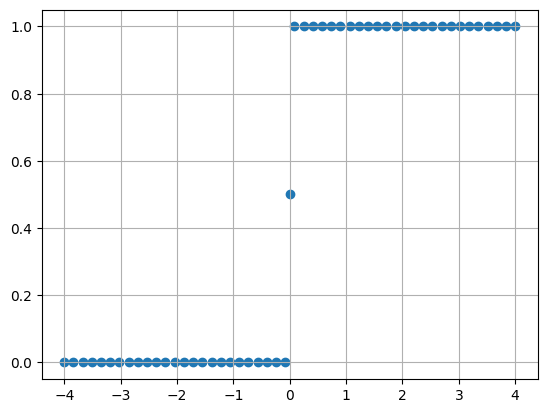

In [62]:
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt

X_range=list(np.linspace(-4,4,50))
X_range.append(0)
X_range.sort()

def func(x):
    if x<0:
        return 0
    elif x==0:
        return 0.5
    else:
        return 1
    
y_range=np.array([func(x) for x in X_range])

plt.scatter(X_range,y_range)
plt.grid()

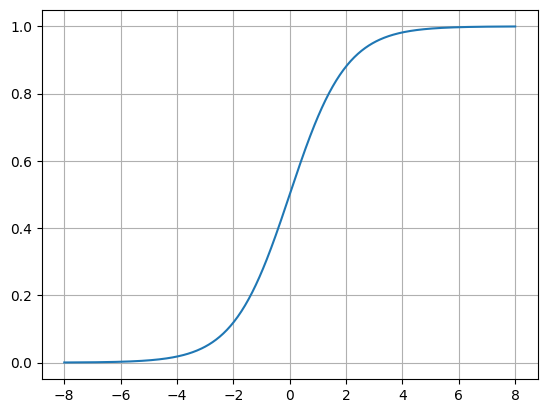

In [63]:
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt

X_range=list(np.linspace(-8,8,500))
X_range.append(0)
X_range.sort()

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
y_range=np.array([sigmoid(x) for x in X_range])

plt.plot(X_range,y_range)
plt.grid()

In [64]:
from pandas import read_csv
import numpy as np
from scipy import optimize as opt
from scipy import stats as st

In [65]:
data=read_csv("../데이터/고객대출등급예측.csv")

In [66]:
data

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


---

1. 근로기간 특성 확인

In [67]:
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import base as base

In [68]:
test_num=data.대출기간.map(lambda x: "".join([num for num in x if num.isdigit()]))
test_alpha=data.대출기간.map(lambda x: "".join([num for num in x if num.isalpha()]))

기준이 months 인지 확인

In [69]:
test_alpha.unique()

array(['months'], dtype=object)

In [70]:
class LoanTime(base.BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.base_=["months"]
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.map(lambda x: int("".join([num for num in x if num.isdigit()])))

In [71]:
test_pre=LoanTime()

In [72]:
test_pre.fit(data[["대출기간"]])

LoanTime()

In [73]:
test_pre.transform(data[["대출기간"]])

,대출기간
0,36
1,60
2,36
3,36
4,60
...,...
96289,36
96290,60
96291,36
96292,36


----

2. 주택소유상태 확인

In [74]:
house_stats=data.주택소유상태.unique()
print(house_stats)

['RENT' 'MORTGAGE' 'OWN' 'ANY']


---

3. 근로기간

In [75]:
data.근로기간.unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

순위를 생성해야 전처리 가능합니다

In [76]:
working_time=list(data.근로기간.unique())

In [77]:
def remove_string(letter:str,rm_list:list):
    for rm_ in rm_list:
        letter=letter.replace(rm_,"")
    letter=letter.replace(" ","")
    return letter.strip()

In [78]:
['Unknown',"<1"]+[str(x) for x in range(1,10)]+["10+"]

['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']

In [79]:
from numpy import ndarray
class WorkingTime(base.BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.ord_encoder=pre.OrdinalEncoder(
            categories=[['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )
    def fit(self,X,y=None):
        def remove_string(letter:str,rm_list:list):
            for rm_ in rm_list:
                letter=letter.replace(rm_,"")
            return letter.strip()
        tr_X=X.map(lambda x: remove_string(x,["years","year"]))
        self.ord_encoder.fit(tr_X)
        return self.ord_encoder
    def transform(self, X,y=None) -> ndarray:
        tr_X=X.map(lambda x: remove_string(x,["years","year"]))
        return self.ord_encoder.transform(tr_X)


In [80]:
test_ord=WorkingTime()

In [81]:
test_ord.fit(data[["근로기간"]])

OrdinalEncoder(categories=[['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7',
                            '8', '9', '10+']],
               handle_unknown='use_encoded_value', unknown_value=-1)

In [82]:
test_ord.transform(data[["근로기간"]])

array([[ 7.],
       [11.],
       [ 6.],
       ...,
       [ 2.],
       [ 6.],
       [11.]])

4. 대출목적

In [83]:
purpose_loan=data.대출목적.unique()
print(purpose_loan)

['부채 통합' '주택 개선' '주요 구매' '휴가' '의료' '자동차' '신용 카드' '소규모 사업' '기타' '이사' '주택'
 '재생 에너지']


---

## 이진분류의 예시

In [84]:
data.대출등급.value_counts()

대출등급
B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: count, dtype: int64

B,C 의 샘플 개수가 굉장히 비슷함

따라서 이 둘을 가지고 이진분류 모델을 만들어 보겠습니다

In [94]:
bi_data=data[(data.대출등급=="B")|(data.대출등급=="C")]

#### 전처리 파이프 라인

In [95]:
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import model_selection as mod
from sklearn import linear_model as lin

In [96]:
cates=[house_stats,purpose_loan]
one_hot=pre.OneHotEncoder(categories=cates,handle_unknown="ignore",drop="if_binary")

num_cols=bi_data.select_dtypes(np.number).columns.to_list()


prepreocess_=com.ColumnTransformer((("대출기간",LoanTime(),["대출기간"]),
                      ("근로기간",WorkingTime(),["근로기간"]),
                      ("이산형특성",one_hot,["주택소유상태","대출목적"]),
                      ("연속형특성","passthrough",num_cols)),
                      remainder="drop",verbose=True)

확인

In [97]:
prepreocess_.fit(bi_data)

[ColumnTransformer] .......... (1 of 4) Processing 대출기간, total=   0.1s
[ColumnTransformer] .......... (2 of 4) Processing 근로기간, total=   0.0s
[ColumnTransformer] ......... (3 of 4) Processing 이산형특성, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing 연속형특성, total=   0.0s


ColumnTransformer(transformers=(('대출기간', LoanTime(), ['대출기간']),
                                ('근로기간', WorkingTime(), ['근로기간']),
                                ('이산형특성',
                                 OneHotEncoder(categories=[array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object),
                                                           array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)],
                                               drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['주택소유상태', '대출목적']),
                                ('연속형특성', 'passthrough',
                                 ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                                  '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                                  '연체계좌수'])),
                  verbose=True)

In [98]:
prepreocess_.transform(bi_data)

array([[3.60000e+01, 7.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.00000e+01, 1.10000e+01, 0.00000e+00, ..., 2.34060e+05,
        0.00000e+00, 0.00000e+00],
       [3.60000e+01, 9.00000e+00, 0.00000e+00, ..., 1.53108e+05,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.60000e+01, 0.00000e+00, 0.00000e+00, ..., 6.20328e+05,
        0.00000e+00, 0.00000e+00],
       [3.60000e+01, 1.10000e+01, 0.00000e+00, ..., 4.92168e+05,
        0.00000e+00, 0.00000e+00],
       [3.60000e+01, 1.10000e+01, 1.00000e+00, ..., 2.74956e+05,
        0.00000e+00, 0.00000e+00]])

### 로지스틱 회귀 모델 만들기

In [99]:
LogitRg=pip.Pipeline([("전처리",prepreocess_),
                      ("로지스틱회귀",lin.LogisticRegression())])

In [100]:
LogitRg.fit(X=bi_data,y=bi_data["대출등급"])

[ColumnTransformer] .......... (1 of 4) Processing 대출기간, total=   0.1s
[ColumnTransformer] .......... (2 of 4) Processing 근로기간, total=   0.0s
[ColumnTransformer] ......... (3 of 4) Processing 이산형특성, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing 연속형특성, total=   0.0s


Pipeline(steps=[('전처리',
                 ColumnTransformer(transformers=(('대출기간', LoanTime(), ['대출기간']),
                                                 ('근로기간', WorkingTime(),
                                                  ['근로기간']),
                                                 ('이산형특성',
                                                  OneHotEncoder(categories=[array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object),
                                                                            array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)],
                                                                drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['주택소유상태', '대출목적']),
                                                 ('연속형특성', 'passthrough',
                                                  ['대출금액', '연간소득',
                                                   '부채_대비_소득_비율', '총계좌수',
                                                   '최근_2년간_연체_횟수', '총상환원금',
                                                   '총상환이자', '총연체금액',
                                                   '연체계좌수'])),
                                   verbose=True)),
                ('로지스틱회귀', LogisticRegression())])

### 교차검증 진행

10겹 10차로 진행하며, 혼동행렬을 확인하겠습니다.

In [ ]:
from sklearn import model_selection as mod
from sklearn import metrics as met

precision_score=met.make_scorer(met.precision_score,pos_label="B")
recall_score=met.make_scorer(met.recall_score,pos_label="B")
accuracy_score=met.make_scorer(met.accuracy_score)

kfold=mod.RepeatedStratifiedKFold(n_splits=10,n_repeats=10,random_state=1)

history=mod.cross_validate(estimator=LogitRg,X=bi_data,y=bi_data["대출등급"],cv=kfold,
                           scoring={"accuracy":accuracy_score,
                                    "precision":precision_score,
                                    "recall":recall_score})

In [117]:
history["test_accuracy"].mean()

np.float64(0.7144737774627924)

In [119]:
history["test_accuracy"].std()

np.float64(0.006366163396915021)